# MCMC tutorial publication results and plotting
Part of the Bayesian neural networks via MCMC: a Python-based tutorial

This notebook contains the code used to generate the results and plots for the paper.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import glob, warnings
from ipywidgets import interact, fixed, widgets
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir('/project')

from publication_results.models.mcmc import MCMC
from publication_results.convergence.convergence import gelman_rubin

## Load the results from the MCMC runs
Load in the results stored in the netcdf files.

In [40]:
models = ['linear','bnn'] #['linear_tp','bnn_tp']
data = ['Sunspot', 'Abalone', 'Iris', 'Ionosphere']
results_dir = os.path.join('publication_results','results')

results = {mm: {dd: None for dd in data} for mm in models}
for this_model in models:
    mod_results_dir = os.path.join(results_dir,'{}_model'.format(this_model))
    for this_data in data:
        # load all of the chains
        results_files = glob.glob(os.path.join(mod_results_dir,'mcmc_{}_*.nc'.format(this_data)))
        print('Found {} results files for {} model on {} data'.format(len(results_files),this_model,this_data))
        tmp_data = xr.open_mfdataset(results_files, combine='nested',concat_dim='chain')
        # re-ID the chains
        tmp_data.coords['chain'] = np.arange(len(results_files))
        results[this_model][this_data] = tmp_data

Found 5 results files for linear model on Sunspot data
Found 5 results files for linear model on Abalone data
Found 5 results files for linear model on Iris data
Found 5 results files for linear model on Ionosphere data
Found 5 results files for bnn model on Sunspot data
Found 5 results files for bnn model on Abalone data
Found 5 results files for bnn model on Iris data
Found 5 results files for bnn model on Ionosphere data


In [41]:
# load the data
x_train = {}
y_train = {}
x_test = {}
y_test = {}

for this_data in data:
    train_data   = np.loadtxt("data/{}/train.txt".format(this_data))
    test_data    = np.loadtxt("data/{}/test.txt".format(this_data))

    x_train[this_data] = train_data[:,:-1]
    y_train[this_data] = train_data[:,-1]
    x_test[this_data] = test_data[:,:-1]
    y_test[this_data] = test_data[:,-1]

# little lookup table
data_case = {'Sunspot':'regression','Abalone':'regression','Iris':'classification','Ionosphere':'classification'}

## Evaluate the model performance
Calculate the model performance metrics for the MCMC samples.

In [49]:
results_table = []# pd.DataFrame(columns=['train','test','model','data'])
for this_model in models:
    for this_data in data:
        # here we are collecting RMSE and accuracy for train and test
        train_dim = results[this_model][this_data].coords['train_idx'].shape[0]
        test_dim = results[this_model][this_data].coords['test_idx'].shape[0]
        train_pred = results[this_model][this_data].train_pred.values.reshape((-1,train_dim))
        test_pred = results[this_model][this_data].test_pred.values.reshape((-1,test_dim))
        
        # Print the train/test RMSE or accuracy in tabular format
        if data_case[this_data] == 'regression':
            train_perf = np.array([MCMC.rmse(train_pred[_,:], y_train[this_data]) for _ in np.arange(train_pred.shape[0])])
            test_perf = np.array([MCMC.rmse(test_pred[_,:], y_test[this_data]) for _ in np.arange(test_pred.shape[0])])

        elif data_case[this_data] == 'classification':
            train_perf = np.array([MCMC.accuracy(train_pred[_,:], y_train[this_data]) for _ in np.arange(train_pred.shape[0])])
            test_perf = np.array([MCMC.accuracy(test_pred[_,:], y_test[this_data]) for _ in np.arange(test_pred.shape[0])])

        results_table.append(
            {
                'train_mean':train_perf.mean(),'test_mean':test_perf.mean(),
                'train_std':train_perf.std(),'test_std':test_perf.std(),
                'model':this_model,'data':this_data
            }
        )
results_table = pd.DataFrame(results_table)
results_table

,train_mean,test_mean,train_std,test_std,model,data
0,0.025217,0.021724,0.013317,0.011669,linear,Sunspot
1,0.085271,0.085565,0.007065,0.006940,linear,Abalone
2,89.478438,84.196430,3.524346,6.132746,linear,Iris
3,89.059739,85.316038,1.335095,2.389743,linear,Ionosphere
4,0.026671,0.026011,0.004681,0.004635,bnn,Sunspot
5,0.079517,0.079715,0.001996,0.001845,bnn,Abalone
6,98.062019,95.426151,0.660752,1.019753,bnn,Iris
7,99.631869,92.668491,0.356123,1.890454,bnn,Ionosphere


## Run convergence diagnostics
Run convergence diagnostics on the MCMC chains to get $\hat{R}$.

In [43]:
# Run the convergence diagnostics
model_r_hat = []
for this_model in models:
    r_hat_collect = []
    data_collect = []
    for this_data in data:
        print('Convergence diagnostics for {} model on {} data'.format(this_model,this_data))
        # combine the parameters together into a single xarray
        params = results[this_model][this_data].drop(['train_pred','test_pred','train_sim','test_sim']).copy()
        params = params.drop_vars(['train_idx','test_idx'])
        
        # combine all variables together along a new dimension
        params = params.to_stacked_array(new_dim='param', sample_dims=['chain','samples'])
        
        # compute the Gelman-Rubin statistic
        if not '_tp' in this_model:
            gr = gelman_rubin(params.values)
        else:
            gr = 999.0 * np.ones((params.shape[-1],))

        # store results as an additional variable in xarray

        param_names = np.array([_[0] for _ in params.param.values])

        results[this_model][this_data] = results[this_model][this_data].assign_coords(param=param_names)
        results[this_model][this_data] = results[this_model][this_data].assign(rhat=((['param'],gr)))

        r_hat_collect.append(gr)
        data_collect.extend(gr.shape[0]*[this_data])

    r_hat_collect = pd.DataFrame(
        np.concatenate(
            r_hat_collect,
            axis=0
        ),
        columns=['rhat']
    )
    if this_model == 'linear':
        r_hat_collect['model'] = this_model.title()
    else:
        r_hat_collect['model'] = this_model.upper()
    r_hat_collect['data'] = data_collect

    model_r_hat.append(r_hat_collect)

model_r_hat = pd.concat(model_r_hat)

Convergence diagnostics for linear model on Sunspot data
Convergence diagnostics for linear model on Abalone data
Convergence diagnostics for linear model on Iris data
Convergence diagnostics for linear model on Ionosphere data
Convergence diagnostics for bnn model on Sunspot data
Convergence diagnostics for bnn model on Abalone data
Convergence diagnostics for bnn model on Iris data
Convergence diagnostics for bnn model on Ionosphere data


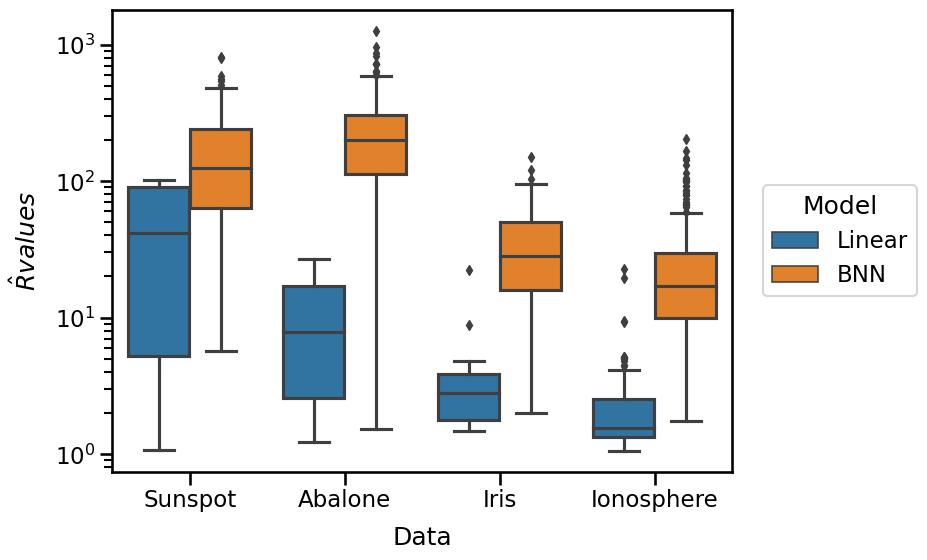

In [46]:
# plot a box and whisker plot with seaborn and the r_hat values
sns.set_context('talk')
fig, ax = plt.subplots(1,1,figsize=(8,6))
sns.boxplot(x='data',y='rhat',hue='model',data=model_r_hat,ax=ax)
ax.set_ylabel('$\hat{R} values$', labelpad=10)
ax.set_xlabel('Data', labelpad=10)
# y on log scale 
ax.set_yscale('log')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
ax.get_legend().set_title('Model')

if not 'linear_tp' in models:
    fig_dir = os.path.join(
        results_dir,
        'figures',
        'convergence'
    )
    os.makedirs(fig_dir, exist_ok=True)
    fig.savefig(os.path.join(fig_dir,'rhat_boxplot.png'),dpi=300,bbox_inches='tight')
plt.show()


In [56]:
# print this in a tabular format for the paper
results_r_hat = results_table.copy()
results_r_hat.set_index(['model','data'],inplace=True)
for this_model in models:
    # Oops I made this messy
    if this_model == 'linear':
        this_model_rhat = this_model.title()
    else:
        this_model_rhat = this_model.upper()
    # grab all the data for the table
    for this_data in data:
        results_r_hat.loc[(this_model,this_data),'mean r_hat'] = model_r_hat.loc[(model_r_hat.model==this_model_rhat) & (model_r_hat.data==this_data),'rhat'].mean()
        results_r_hat.loc[(this_model,this_data),'std r_hat'] = model_r_hat.loc[(model_r_hat.model==this_model_rhat) & (model_r_hat.data==this_data),'rhat'].std()

results_r_hat

train_mean  test_mean  train_std  test_std  mean r_hat  \
model  data                                                                 
linear Sunspot       0.025217   0.021724   0.013317  0.011669   47.916203   
       Abalone       0.085271   0.085565   0.007065  0.006940   10.380834   
       Iris         89.478438  84.196430   3.524346  6.132746    4.369845   
       Ionosphere   89.059739  85.316038   1.335095  2.389743    2.801917   
bnn    Sunspot       0.026671   0.026011   0.004681  0.004635  186.176963   
       Abalone       0.079517   0.079715   0.001996  0.001845  262.824773   
       Iris         98.062019  95.426151   0.660752  1.019753   36.041940   
       Ionosphere   99.631869  92.668491   0.356123  1.890454   24.836422   

                    std r_hat  
model  data                    
linear Sunspot      47.447440  
       Abalone       9.304443  
       Iris          5.107664  
       Ionosphere    3.571828  
bnn    Sunspot     185.012576  
       Abalone     229.213525  
       Iris         28.408710  
       Ionosphere   25.123081

## Plot posterior and trace
Plot the posterior distributions and trace plots for the MCMC samples.

In [57]:
# Now plot posterior distribution and trace plot for selected parameters
def plot_posterior(this_model, this_data, this_param, chain=0, save_dir=None):
    '''
    Plot the posterior as a histogram and then the traceplot
    '''
    plot_data = results[this_model][this_data][this_param].sel(chain=chain)
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    # plot the posterior distribution
    sns.histplot(plot_data.values, ax=ax, bins=20)
    ax.set_xlabel(this_param, labelpad=10)
    ax.set_ylabel('Frequency', labelpad=10)
    ax.set_title('Posterior distribution', pad=10)
    fig.tight_layout()
    
    # plot the trace plot
    fig1, ax1 = plt.subplots(1,1,figsize=(6,4))
    sns.lineplot(x=plot_data.coords['samples'].values,y=plot_data.values,ax=ax1)
    ax1.set_xlabel('Samples', labelpad=10)
    ax1.set_ylabel(this_param, labelpad=10)
    ax1.set_title('Trace plot', pad=10)

    fig1.tight_layout()
    
    if not save_dir is None:
        fig.savefig(os.path.join(save_dir,'{}_{}_{}_posterior.png'.format(this_model,this_data,this_param)))
        fig1.savefig(os.path.join(save_dir,'{}_{}_{}_trace.png'.format(this_model,this_data,this_param)))


# Now use interact to plot for given model, data, param
warnings.simplefilter(action='ignore', category=FutureWarning)
interact(
    plot_posterior, 
    this_model=widgets.Dropdown(options=models, value=models[0]),
    this_data=widgets.Dropdown(options=data, value=data[0]),
    this_param=widgets.SelectionSlider(options=results[models[0]][data[0]].coords['param'].values, value=results[models[0]][data[0]].coords['param'].values[0]),
    chain=widgets.IntSlider(min=0,max=results[models[0]][data[0]].coords['chain'].shape[0]-1,step=1,value=0),
    save_dir=fixed(None)
)
None

interactive(children=(Dropdown(description='this_model', options=('linear', 'bnn'), value='linear'), Dropdown(…

In [58]:
fig_dir = os.path.join(
    results_dir,
    'figures',
    'posterior'
)
os.makedirs(fig_dir, exist_ok=True)
if 'linear_tp' in models:
    plot_posterior('linear_tp','Sunspot','w0',chain=0,save_dir=fig_dir)
    plot_posterior('bnn_tp','Sunspot','w1',chain=0,save_dir=fig_dir)
